In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
class FFN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN):
        super().__init__()
        activation = nn.Tanh
        self.ffni = nn.Sequential(nn.Linear(N_INPUT, N_HIDDEN), activation())
        self.ffnh = nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation())
        self.ffne = nn.Sequential(nn.Linear(N_HIDDEN, N_OUTPUT))

    def forward(self, x):
        x = self.ffni(x)
        x = self.ffnh(x)
        x = self.ffnh(x)
        x = self.ffne(x)
        return x

In [85]:
Lx = 1
Ly = 1
Nx = 11
Ny = 11
x = torch.linspace(0, Lx, Nx).squeeze(0)
y = torch.linspace(0, Ly, Ny).squeeze(0)
X, Y = np.meshgrid(x, y)
x_col = torch.tensor(X.flatten(), dtype=torch.float32).unsqueeze(1)
y_col = torch.tensor(Y.flatten(), dtype=torch.float32).unsqueeze(1)

# x_left = torch.zeros(Ny, 1)
# y_left = torch.linspace(0, Ly, Ny).unsqueeze(1)
# print(x_left.size())
# print(y_left.size())

# k = torch.cat([x_col, y_col], dim=1)
# print(k.size())

# torch.zeros(Ny, 1)
# torch.linspace(0, Ly, Ny).unsqueeze(1).size()
x_left = torch.zeros(Ny, 1)
y_left = torch.linspace(0, Ly, Ny).unsqueeze(1)

x_right = Lx * torch.ones(Ny, 1)
y_right = torch.linspace(0, Ly, Ny).unsqueeze(1)

x_bottom = torch.linspace(0, Lx, Nx).unsqueeze(1)
y_bottom = torch.zeros(Nx, 1)

x_top = torch.linspace(0, Lx, Nx).unsqueeze(1)
y_top = Ly * torch.ones(Nx, 1)

k = [
    (x_left, y_left, 100),     # Left boundary (0°C)
    (x_right, y_right, 0),   # Right boundary (0°C)
    (x_bottom, y_bottom, 0), # Bottom boundary (0°C)
    (x_top, y_top, 100)      # Top boundary (100°C)
]


# Generate points
# collocation_points, boundaries = generate_points(Nx, Ny, Lx, Ly)
# print(collocation_points)
# print(len(collocation_points))
# generate_points?
# k = (x_col,y_col)
print(k)

[(tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]), tensor([[0.0000],
        [0.1000],
        [0.2000],
        [0.3000],
        [0.4000],
        [0.5000],
        [0.6000],
        [0.7000],
        [0.8000],
        [0.9000],
        [1.0000]]), 100), (tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.]]), tensor([[0.0000],
        [0.1000],
        [0.2000],
        [0.3000],
        [0.4000],
        [0.5000],
        [0.6000],
        [0.7000],
        [0.8000],
        [0.9000],
        [1.0000]]), 0), (tensor([[0.0000],
        [0.1000],
        [0.2000],
        [0.3000],
        [0.4000],
        [0.5000],
        [0.6000],
        [0.7000],
        [0.8000],
        [0.9000],
        [1.0000]]), tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
    

In [62]:
# x = torch.randn(2,4,1,2)
# print(x.size())
# y = torch.squeeze(x, dim = 2)
# print(y.size())
# z = torch.unsqueeze(y, 2)
# print(z.size())

In [63]:
# Generate Domain and Boundary Points
def generate_points(Nx, Ny, Lx, Ly):
    # Interior points
    x = np.linspace(0, Lx, Nx)
    y = np.linspace(0, Ly, Ny)
    X, Y = np.meshgrid(x, y)
    x_col = torch.tensor(X.flatten(), dtype=torch.float32).unsqueeze(1)
    y_col = torch.tensor(Y.flatten(), dtype=torch.float32).unsqueeze(1)

    # Boundary points
    x_left = torch.zeros(Ny, 1)
    y_left = torch.linspace(0, Ly, Ny).unsqueeze(1)

    x_right = Lx * torch.ones(Ny, 1)
    y_right = torch.linspace(0, Ly, Ny).unsqueeze(1)

    x_bottom = torch.linspace(0, Lx, Nx).unsqueeze(1)
    y_bottom = torch.zeros(Nx, 1)

    x_top = torch.linspace(0, Lx, Nx).unsqueeze(1)
    y_top = Ly * torch.ones(Nx, 1)

    boundaries = [
        (x_left, y_left, 100),     # Left boundary (0°C)
        (x_right, y_right, 0),   # Right boundary (0°C)
        (x_bottom, y_bottom, 0), # Bottom boundary (0°C)
        (x_top, y_top, 100)      # Top boundary (100°C)
    ]

    return (x_col, y_col), boundaries

In [64]:
# PDE Residual Loss
def pde_residual_loss(model, x, y):
    x.requires_grad = True
    y.requires_grad = True

    T = model(torch.cat([x, y], dim=1))  # Neural network prediction T(x, y)

    # First derivatives
    grad_T = torch.autograd.grad(T, [x, y], grad_outputs=torch.ones_like(T), create_graph=True)
    T_x, T_y = grad_T[0], grad_T[1]  # dT/dx, dT/dy

    # Second derivatives
    T_xx = torch.autograd.grad(T_x, x, grad_outputs=torch.ones_like(T_x), create_graph=True)[0]
    T_yy = torch.autograd.grad(T_y, y, grad_outputs=torch.ones_like(T_y), create_graph=True)[0]

    # Residual of Laplace's equation
    residual = T_xx + T_yy  # ∂²T/∂x² + ∂²T/∂y²

    loss_residual = torch.mean(residual**2)
    return loss_residual

# Boundary Loss
def boundary_loss(model, x_boundary, y_boundary, T_exact):
    T_pred = model(torch.cat([x_boundary, y_boundary], dim=1))
    loss_boundary = torch.mean((T_pred - T_exact)**2)
    return loss_boundary

# def intial_loss(model, x, y):
    

# Total Loss Function
def total_loss(model, collocation_points, boundaries):
    # PDE Residual Loss
    x_col, y_col = collocation_points
    loss_pde = pde_residual_loss(model, x_col, y_col)

    # Boundary Losses
    loss_boundary = 0
    for boundary in boundaries:
        x_b, y_b, T_exact_val = boundary
        T_exact = T_exact_val * torch.ones_like(x_b)
        loss_boundary += boundary_loss(model, x_b, y_b, T_exact)

    # Combine losses
    total_loss = loss_pde + loss_boundary
    return total_loss

In [65]:
def plot_temperature(model, X, Y, epoch, Nx, Ny):
    # Flatten the input grids to create input data
    x_flat = X.reshape(-1, 1)
    y_flat = Y.reshape(-1, 1)

    # Predict temperature values using the model
    with torch.no_grad():
        T_pred = model(torch.cat([x_flat, y_flat], dim=1)).reshape(Nx, Ny)

    # Plot the temperature distribution
    plt.figure(figsize=(8, 6))
    plt.contourf(X.numpy(), Y.numpy(), T_pred.numpy(), cmap='jet', levels=60)
    plt.colorbar(label='Temperature (°C)')
    plt.title(f'Temperature Distribution at Epoch {epoch}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()


Epoch 0, Loss: 19966.568359


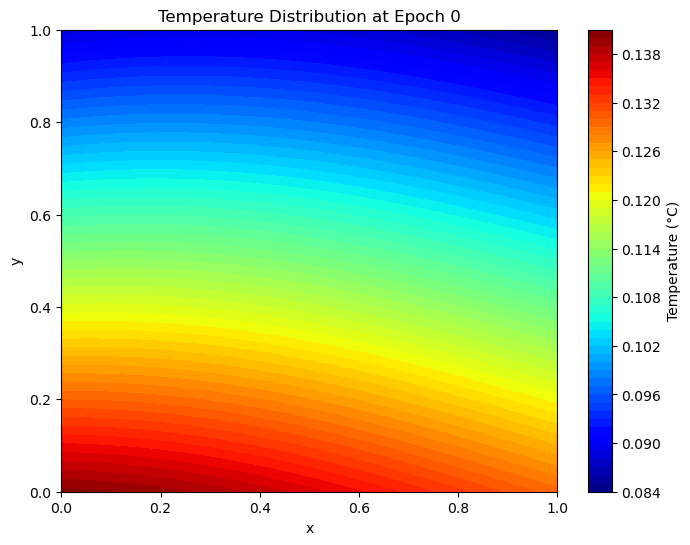

Epoch 500, Loss: 15313.791016


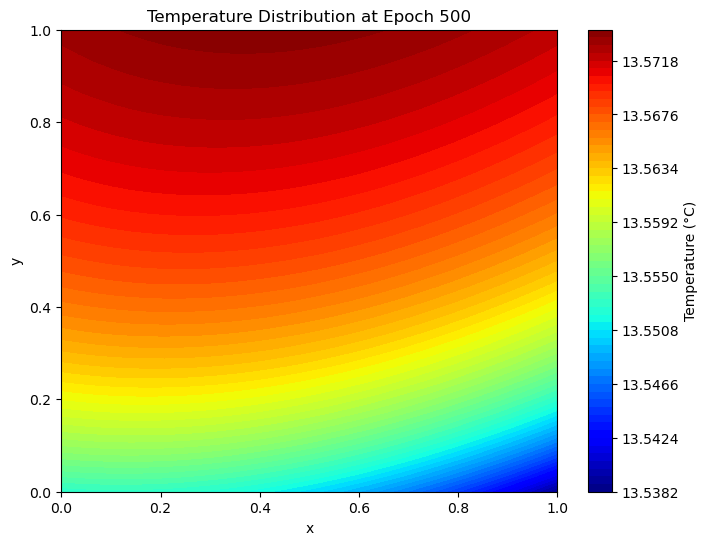

Epoch 1000, Loss: 12826.397461


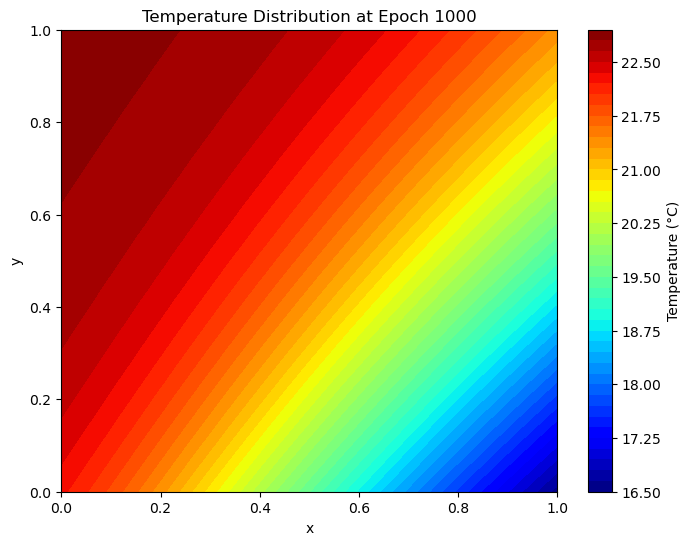

Epoch 1500, Loss: 10139.253906


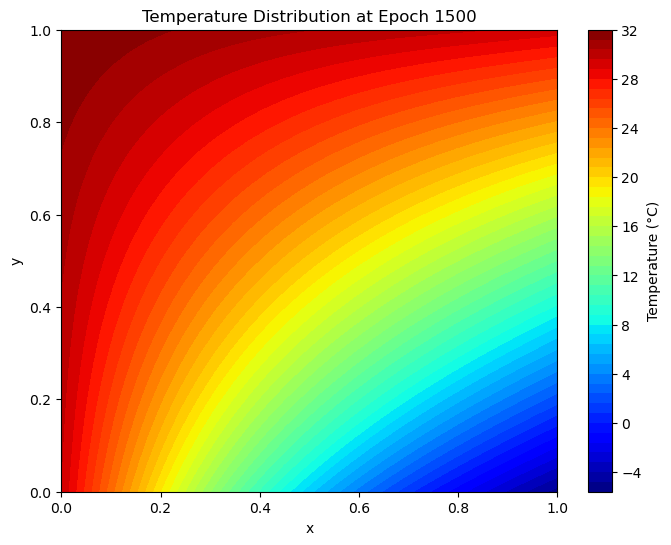

Epoch 2000, Loss: 8018.576172


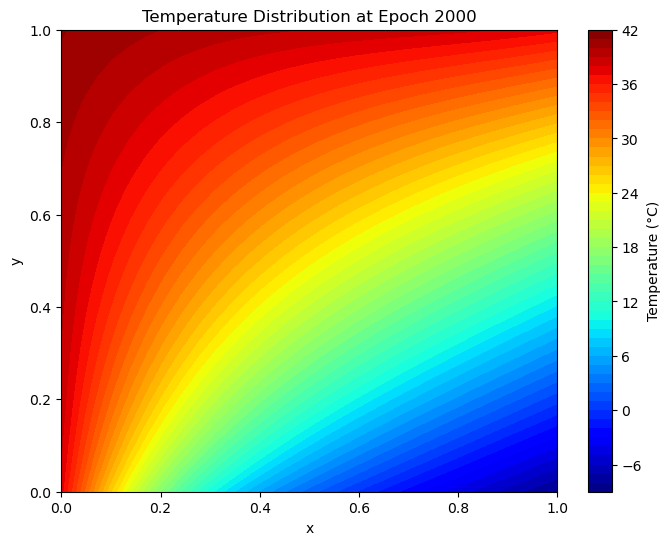

Epoch 2500, Loss: 6233.326660


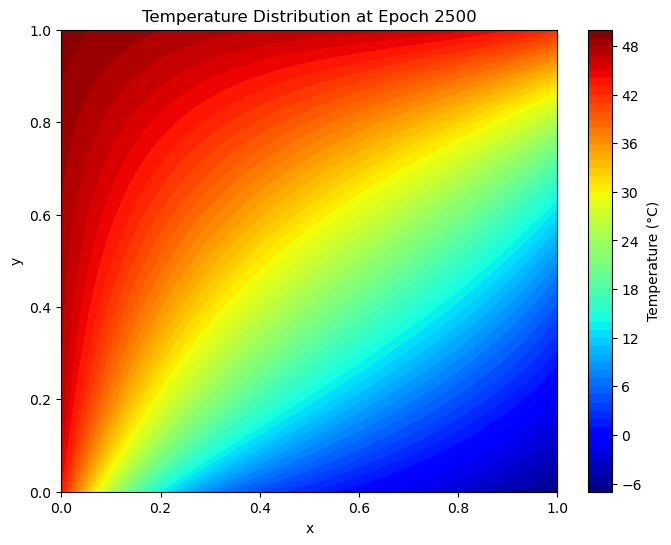

Epoch 3000, Loss: 4817.884277


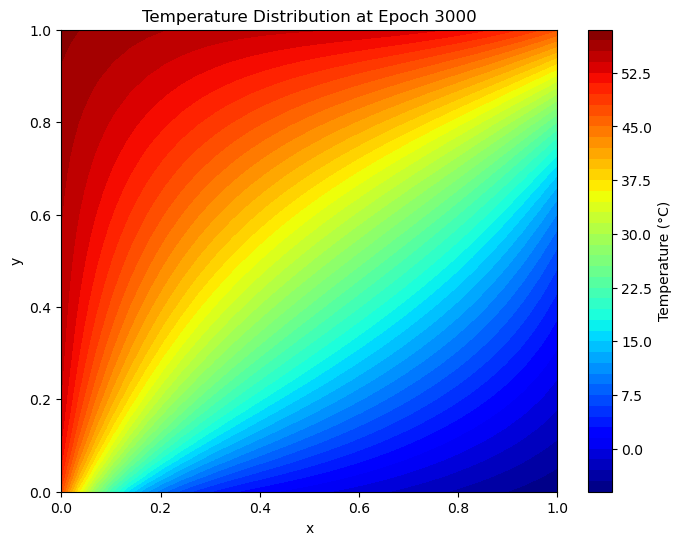

Epoch 3500, Loss: 3704.196045


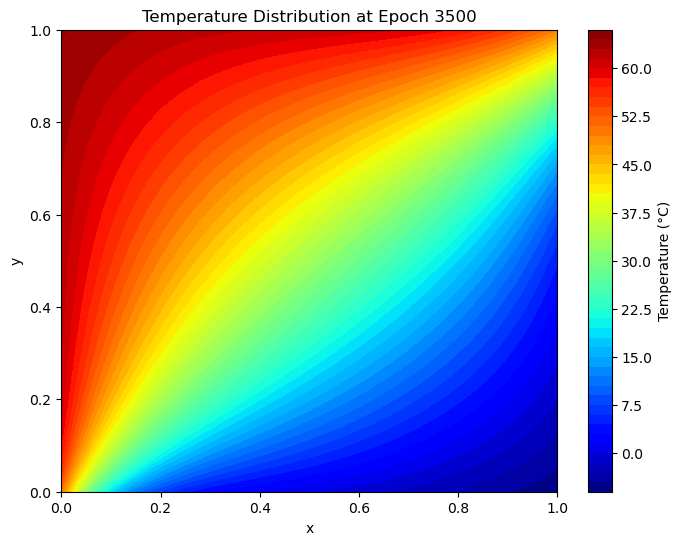

Epoch 4000, Loss: 2833.626953


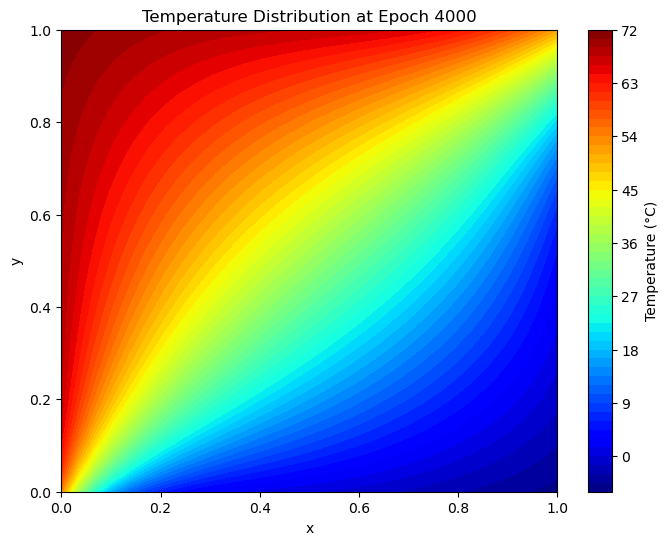

Epoch 4500, Loss: 2160.737305


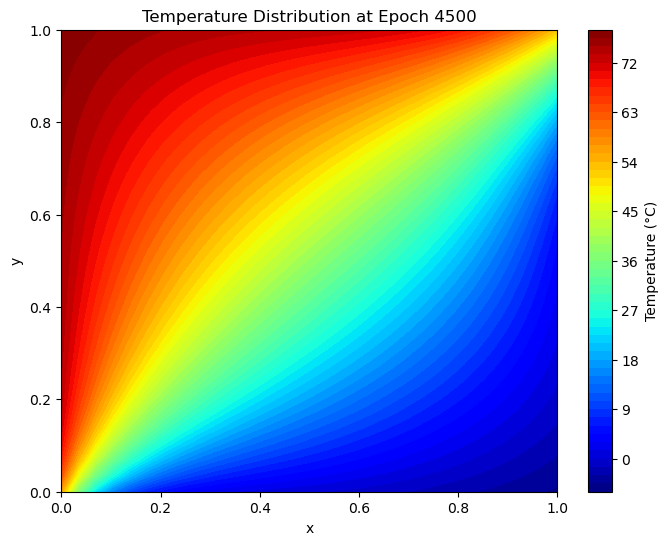

Epoch 4999, Loss: 1678.375244


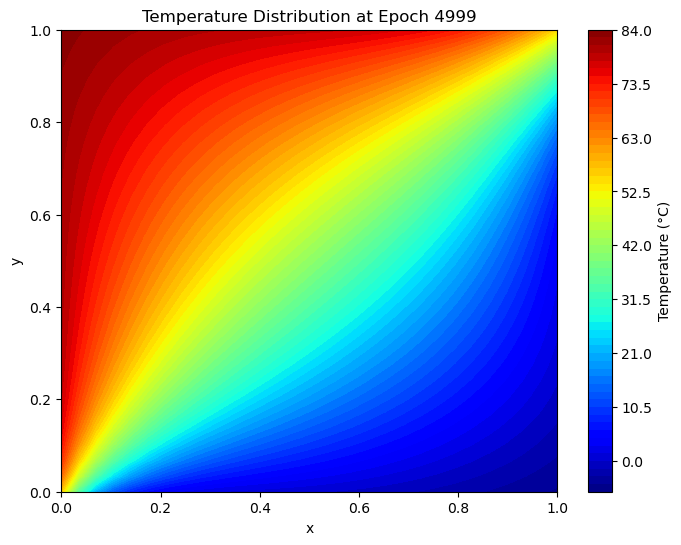

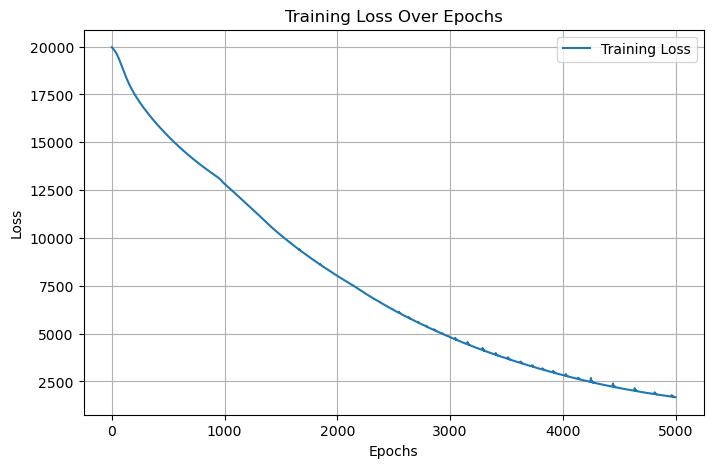

In [90]:
# Main Function
def main():
    # Parameters
    Lx, Ly = 1.0, 1.0   # Domain dimensions
    Nx, Ny = 30, 30     # Number of points in x and y directions
    hidden_dim = 20     # Hidden layer size
    epochs = 5000       # Number of training epochs
    lr = 1e-3           # Learning rate

    # Generate points
    collocation_points, boundaries = generate_points(Nx, Ny, Lx, Ly)

    # Model and Optimizer
    model = FFN(2, 1, hidden_dim)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training Loop
    losses = []
    x = torch.linspace(0, Lx, Nx)
    y = torch.linspace(0, Ly, Ny)
    X, Y = torch.meshgrid(x, y)

    for epoch in range(epochs):
        optimizer.zero_grad()

        # Compute total loss
        loss = total_loss(model, collocation_points, boundaries)

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Track progress
        losses.append(loss.item())
        if epoch % 500 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
            plot_temperature(model, X, Y, epoch, Nx, Ny)

            
    torch.save(model.state_dict(), "2D_Heat")

    # Final Loss Plot
    plt.figure(figsize=(8, 5))
    plt.plot(losses, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

if __name__ == "__main__":
    main()


In [94]:
new_model = FFN(2,1,20)
new_model.load_state_dict(torch.load("2D_Heat"))

/tmp/ipykernel_4006679/2285361100.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  new_model.load_state_dict(torch.load("2D_Heat"))


<All keys matched successfully>

In [98]:
x_input = 0.8
y_input = 0.8
input_tensor = torch.tensor([[x_input,y_input]])

In [103]:
with torch.no_grad():
    x = new_model(input_tensor)

In [104]:
x

tensor([[44.0663]])